# Importing Data

In [48]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs

from scipy.optimize import curve_fit



In [49]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Nepal Master Sheet.xlsx', sheet_name='Final_compiled')

df_abra = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Abra.xlsx', sheet_name='Sheet1')

df_copy = df.copy()

In [50]:
df_copy = df_copy[df_copy['Sample type'] == 'Spring water']    

In [51]:
# Convert concentrations from ppm to mM
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99
df_copy['Li_mM'] = df_copy['Li_ppm'] / 6.94
df_copy['K_mM'] = df_copy['K_ppm'] / 39.10
df_copy['Al_mM'] = df_copy['Al_ppm'] / 26.98
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000

# Convert Cl from molar to mM
df_copy['Cl_mM'] = df_copy['Cl_molar'] / 1000

# Calculate ion ratios
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']
df_copy['Ca/Na'] = df_copy['Ca_mM'] / df_copy['Na_mM']
df_copy['Mg/Ca'] = df_copy['Mg_mM'] / df_copy['Ca_mM']
df_copy['Mg/Na'] = df_copy['Mg_mM'] / df_copy['Na_mM']
df_copy['Ca/Sr'] = df_copy['Ca_mM'] / df_copy['Sr_mM']
df_copy['1000xSr/Ca'] = df_copy['Sr_mM'] / df_copy['Ca_mM'] * 1000
df_copy['Si/Ca'] = df_copy['Si_mM'] / df_copy['Ca_mM']



df_copy['Si_mol/l'] = df_copy['Si_mM'] / 1000

In [52]:
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None

    # Normalize the GNS by stripping suffixes and quotes
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    
    # S1 group
    if gns.startswith("S1"):
        if gns in ["S1m", "S1i"]:  # Special cases for Traverse 1*
            return "Traverse 1*"
        return "Traverse 1"
    # S2 group
    elif gns.startswith("S2"):
        return "Traverse 2"
    # S3 group
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:  # Special cases for Traverse 4
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:  # Special cases for Traverse 3*
            return "Traverse 3*"
        return "Traverse 3"  # Default case for S3
    # S4 group
    elif gns.startswith("S4"):
        if gns in ["S4m", "S4l"]:  # Special cases for Traverse 5*
            return "Traverse 5*"
        return "Traverse 5"
    # Default case for unknown values
    return None



# Apply the function to create the new column
df_copy["Traverse"] = df_copy["GNS"].apply(assign_traverse)


# Calculating Distance from the Ridge

In [53]:
df_copy = df_copy[df_copy['Traverse'] == 'Traverse 3']

# Calculate distance for Abra samples for their longitude. Do longitude 85.5984 minus the longitude of the sample. Then convert to meters to give a new 'x' column
df_copy['x'] = (85.5984 - df_copy['Longitude']) * 111000

# calculate elevation difference between df_abra['Elevation'] and the elevation of the ridge
df_copy['y'] = 2600 - df_copy['Elevation']

df_copy['x+y'] = df_copy['x'] + df_copy['y']

# calculate sqrt(x^2 + y^2) for each sample
df_copy['distance_from_ridge'] = np.sqrt(df_copy['x']**2 + df_copy['y']**2)

df_copy['2(x+y)'] = 2 * df_copy['x+y']


# print x+y, distance from ridge and 2(x+y)
print(df_copy[['x+y', 'distance_from_ridge', '2(x+y)', 'Sample ID']])

          x+y  distance_from_ridge     2(x+y)  Sample ID
69    841.450           684.803039   1682.900   NEP22-10
70    811.480           655.946667   1622.960   NEP22-11
71    745.020           574.757688   1490.040   NEP22-12
72   1925.130          1509.684489   3850.260   NEP22-13
74   2221.180          1714.180735   4442.360   NEP22-15
75   2113.740          1610.366402   4227.480   NEP22-16
76   1917.470          1503.070591   3834.940   NEP22-17
77   1915.481          1495.750582   3830.962   NEP22-18
78   1940.119          1521.378173   3880.238   NEP22-19
80   1633.750          1241.165204   3267.500   NEP22-20
100  5564.040          4474.537867  11128.080   NEP22-42
102  5947.010          4753.694124  11894.020   NEP22-45
111  3496.880          2797.009742   6993.760   NEP22-53
112  3489.660          2793.418307   6979.320   NEP22-54
113  3511.870          2808.029992   7023.740   NEP22-55
114  5054.220          4058.616554  10108.440   NEP22-56
115  4817.870          3853.136

# Steady State

In [ ]:

variable = 'Si_mol/l'

# define Co
C_zero = df_copy[variable].min()

# define C'
df_copy['C_prime'] = df_copy[variable] / C_zero


#######

# Define porosity: (0.15 for now)
phi = 0.15

rho_min = 2.67 # g/cm^3

rho_sf = 1000 * rho_min / phi # g/cm^3

#######

# nautral log of k is -11.2 from USGS
# for now taking constant in mol/m^2/s

k_eff = np.exp(-11.2)


## Try their rate constant
# k_eff = 8.7 * 10**-6 # mol/m^2/year
# # # convert k_eff to mol/m^2/s
# k_eff = k_eff / (365 * 24 * 3600)


# specific surface area. For now taking constant, the same as Maher and Chamberlain 2014
a_surf = 0.1

# percentage of plagioclase in rock. Update this value
x_r =  0.36

########

# Calculate Rc = rho_sf * k_eff * a_surf * x_r in moles per liter per second
df_copy['Rc'] = rho_sf * k_eff * a_surf * x_r


# Convert Rc to moles per meter cubed per second
#df_copy['Rc'] = df_copy['Rc'] / 1000000 * 1000






In [55]:
# C' =  1 + z'*Nd(1-f)

# for now take f=0

# So 
# (C' - 1)/z' = Nd


# Nd = h * Rc / (omega * phi * C_zero)


# so 1/omega = ((C' -1)/z') * phi * C_zero / h * Rc

# We want to vary an array of h and see how omega varies

# Array of h ranges from df_copy['distance_from_ridge'] to df_copy[2(x+y)] for each sample in 1000 steps
# Create an array of h values ranging from 'distance_from_ridge' to '2(x+y)' for each sample in 1000 steps

# Initialize a dictionary to store h distributions
h_distributions = {}

# Loop through each sample to calculate the h range
for index, row in df_copy.iterrows():
    sample_id = row['Sample ID']  # Assuming 'Sample ID' uniquely identifies each sample
    # Generate 1000 evenly spaced h values for the sample
    h_values = np.linspace(row['distance_from_ridge'], row['2(x+y)'], 1000)
    # Store in the dictionary
    h_distributions[sample_id] = h_values

In [56]:
h_distributions['NEP22-16']

array([1610.36640166, 1612.98613499, 1615.60586832, 1618.22560166,
       1620.84533499, 1623.46506832, 1626.08480165, 1628.70453498,
       1631.32426831, 1633.94400165, 1636.56373498, 1639.18346831,
       1641.80320164, 1644.42293497, 1647.0426683 , 1649.66240164,
       1652.28213497, 1654.9018683 , 1657.52160163, 1660.14133496,
       1662.76106829, 1665.38080163, 1668.00053496, 1670.62026829,
       1673.24000162, 1675.85973495, 1678.47946828, 1681.09920162,
       1683.71893495, 1686.33866828, 1688.95840161, 1691.57813494,
       1694.19786827, 1696.81760161, 1699.43733494, 1702.05706827,
       1704.6768016 , 1707.29653493, 1709.91626826, 1712.5360016 ,
       1715.15573493, 1717.77546826, 1720.39520159, 1723.01493492,
       1725.63466825, 1728.25440159, 1730.87413492, 1733.49386825,
       1736.11360158, 1738.73333491, 1741.35306824, 1743.97280158,
       1746.59253491, 1749.21226824, 1751.83200157, 1754.4517349 ,
       1757.07146823, 1759.69120157, 1762.3109349 , 1764.93066

In [57]:

# Initialize an empty list to store omega values
omega_values = []


# Assume z' = 1 for initial model
df_copy['z_prime'] = 1


# now scaled
# Normalize distance from ridge to scale z_prime
# df_copy['z_prime'] = (df_copy['distance_from_ridge'] - df_copy['distance_from_ridge'].min()) / (
#     df_copy['distance_from_ridge'].max() - df_copy['distance_from_ridge'].min()
# )

# Ensure z_prime is scaled between a defined range, e.g., [0.1, 1]
z_prime_min, z_prime_max = 0, 1
df_copy['z_prime'] = z_prime_min + (df_copy['z_prime'] * (z_prime_max - z_prime_min))

df_copy['z_prime']

69     1
70     1
71     1
72     1
74     1
75     1
76     1
77     1
78     1
80     1
100    1
102    1
111    1
112    1
113    1
114    1
115    1
116    1
117    1
119    1
150    1
173    1
174    1
175    1
176    1
177    1
178    1
179    1
181    1
182    1
183    1
203    1
204    1
205    1
206    1
208    1
210    1
211    1
212    1
213    1
214    1
Name: z_prime, dtype: int64

In [58]:

# Initialize dictionaries to store results
omega_results = {}
residence_time_results = {}


# Loop through each sample to calculate omega and residence time for each h in the h distribution
for sample_id, h_values in h_distributions.items():
    # Extract sample-specific parameters from df_copy
    row = df_copy[df_copy['Sample ID'] == sample_id].iloc[0]
    C_prime = row['C_prime']
    z_prime = row['z_prime']
    Rc = row['Rc']
    
    # Calculate omega for each h value
    omega_values = (((C_prime - 1) / z_prime) * phi * C_zero) / (h_values * Rc)
    omega_results[sample_id] = omega_values
    
    # Calculate residence time for each h value
    residence_times = h_values / omega_values
    
    # Convert residence times to years
    residence_times_years = residence_times / (60 * 60 * 24 * 365.25)
    residence_time_results[sample_id] = residence_times_years



/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_46048/1439391445.py:19: RuntimeWarning: divide by zero encountered in divide
  residence_times = h_values / omega_values


In [59]:
# Initialize lists for plotting
lowest_h_residence_times = []
middle_h_residence_times = []
highest_h_residence_times = []
c_prime_values = []

# Loop through each sample
for sample_id, h_values in h_distributions.items():
    # Extract the h distribution and corresponding results
    residence_times = residence_time_results[sample_id]
    C_prime = df_copy.loc[df_copy['Sample ID'] == sample_id, 'C_prime'].values[0]  # Constant per sample

    # Extract lowest, middle, and highest h indices
    lowest_h_index = 0
    highest_h_index = len(h_values) - 1
    middle_h_index = len(h_values) // 2

    # Append the corresponding residence times
    lowest_h_residence_times.append(residence_times[lowest_h_index])
    middle_h_residence_times.append(residence_times[middle_h_index])
    highest_h_residence_times.append(residence_times[highest_h_index])
    
    # Append the constant C_prime
    c_prime_values.append(C_prime)

# Convert lists to numpy arrays
lowest_h_residence_times = np.array(lowest_h_residence_times)
middle_h_residence_times = np.array(middle_h_residence_times)
highest_h_residence_times = np.array(highest_h_residence_times)
c_prime_values = np.array(c_prime_values)


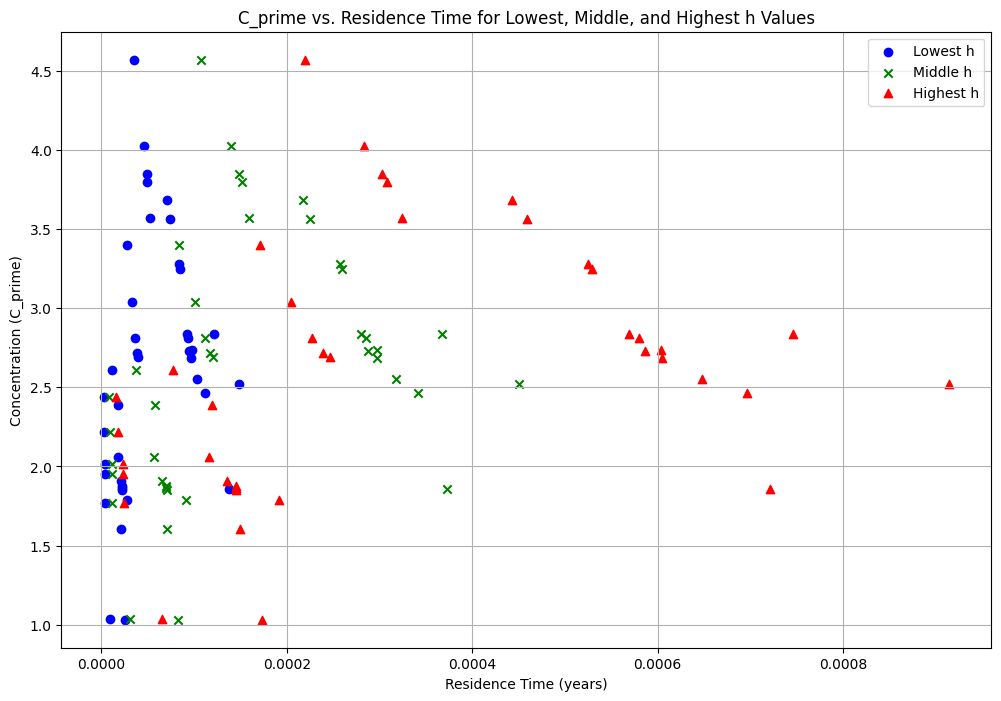

In [60]:
# Plot the results
plt.figure(figsize=(12, 8))

# Plot for lowest h values
plt.scatter(lowest_h_residence_times, c_prime_values, label='Lowest h', color='blue', marker='o')

# Plot for middle h values
plt.scatter(middle_h_residence_times, c_prime_values, label='Middle h', color='green', marker='x')

# Plot for highest h values
plt.scatter(highest_h_residence_times, c_prime_values, label='Highest h', color='red', marker='^')

# Customize plot
plt.xlabel('Residence Time (years)')
plt.ylabel('Concentration (C_prime)')
plt.title('C_prime vs. Residence Time for Lowest, Middle, and Highest h Values')
plt.legend()
plt.grid()
plt.show()

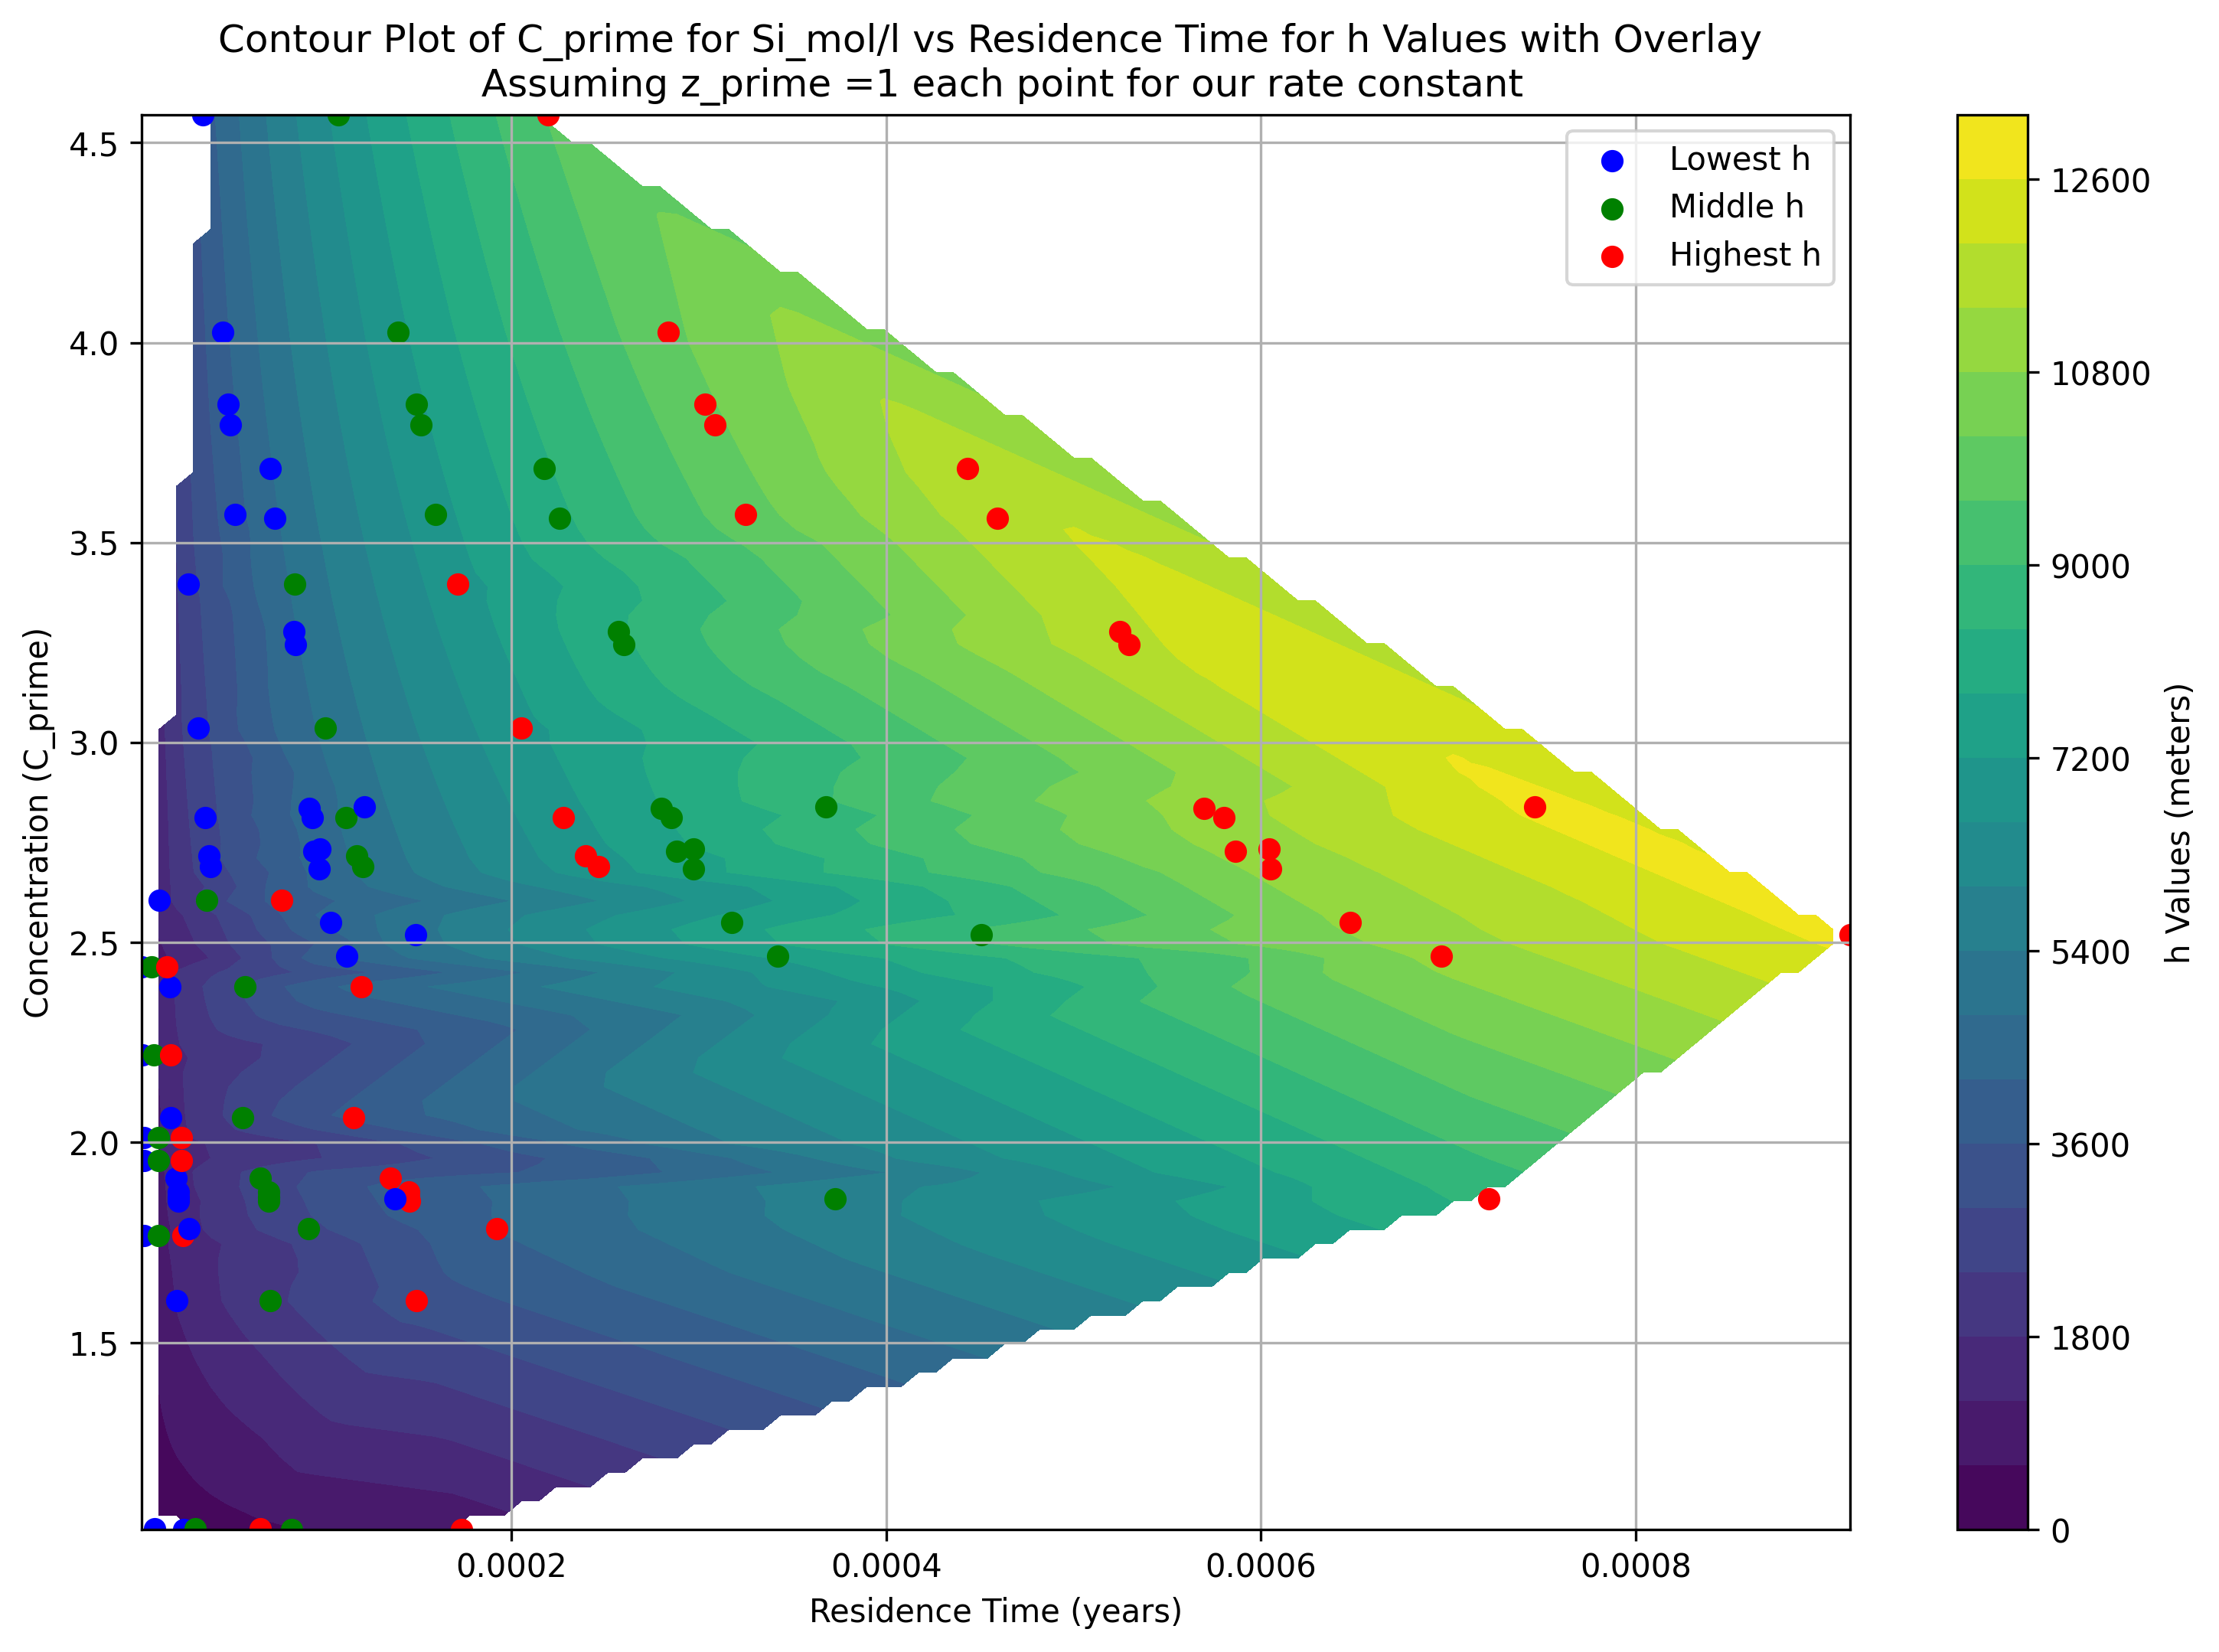

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Prepare grid for contouring
residence_time_grid = []
c_prime_grid = []
h_grid = []

# Loop through each sample to extract data
for sample_id, h_values in h_distributions.items():
    # Get residence times and C_prime for the sample
    residence_times = residence_time_results[sample_id]
    C_prime = df_copy.loc[df_copy['Sample ID'] == sample_id, 'C_prime'].values[0]  # Constant per sample
    
    # Append data to grids
    residence_time_grid.extend(residence_times)
    c_prime_grid.extend([C_prime] * len(h_values))  # C_prime is constant
    h_grid.extend(h_values)

# Convert lists to numpy arrays
residence_time_grid = np.array(residence_time_grid)
c_prime_grid = np.array(c_prime_grid)
h_grid = np.array(h_grid)

# Filter out invalid or duplicate data
valid_indices = ~np.isnan(residence_time_grid) & ~np.isinf(residence_time_grid) & \
                ~np.isnan(c_prime_grid) & ~np.isinf(c_prime_grid) & \
                ~np.isnan(h_grid) & ~np.isinf(h_grid)

residence_time_grid = residence_time_grid[valid_indices]
c_prime_grid = c_prime_grid[valid_indices]
h_grid = h_grid[valid_indices]

# Remove duplicate points
unique_points, unique_indices = np.unique(np.column_stack((residence_time_grid, c_prime_grid)), axis=0, return_index=True)
residence_time_grid = unique_points[:, 0]
c_prime_grid = unique_points[:, 1]
h_grid = h_grid[unique_indices]

# Generate a regular grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(min(residence_time_grid), max(residence_time_grid), 100),
    np.linspace(min(c_prime_grid), max(c_prime_grid), 100)
)

# Interpolate h values onto the regular grid
# Interpolate h values onto the regular grid
try:
    grid_h = griddata(
        (residence_time_grid, c_prime_grid), h_grid, (grid_x, grid_y), method='linear'
    )
except Exception as e:
    print(f"Linear interpolation failed: {e}")
    grid_h = griddata(
        (residence_time_grid, c_prime_grid), h_grid, (grid_x, grid_y), method='nearest'
    )

# Create the contour plot
plt.figure(figsize=(12, 8), dpi = 300)
contour = plt.contourf(grid_x, grid_y, grid_h, levels=20, cmap='viridis')

# Add a color bar to represent h values
plt.colorbar(contour, label='h Values (meters)')

# Overlay lowest, middle, and highest points
for sample_id, h_values in h_distributions.items():
    # Extract residence times and C_prime for the sample
    residence_times = residence_time_results[sample_id]
    C_prime = df_copy.loc[df_copy['Sample ID'] == sample_id, 'C_prime'].values[0]  # Constant per sample
    
    # Get indices for lowest, middle, and highest h values
    lowest_index = 0
    middle_index = len(h_values) // 2
    highest_index = len(h_values) - 1
    
    # Overlay points
    plt.scatter(residence_times[lowest_index], C_prime, color='blue', label='Lowest h' if sample_id == list(h_distributions.keys())[0] else "")
    plt.scatter(residence_times[middle_index], C_prime, color='green', label='Middle h' if sample_id == list(h_distributions.keys())[0] else "")
    plt.scatter(residence_times[highest_index], C_prime, color='red', label='Highest h' if sample_id == list(h_distributions.keys())[0] else "")

# Customize plot
plt.xlabel('Residence Time (years)')
plt.ylabel('Concentration (C_prime)')
plt.title('Contour Plot of C_prime for ' + variable + ' vs Residence Time for h Values with Overlay \n Assuming z_prime =1 each point for our rate constant') 
plt.legend()
plt.grid()
plt.show()

In [62]:
# grouped by site
# date the site
# more older water, etc